# Step 04
# Evaluation of performance

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

import skimage.io
import skimage.morphology
import skimage.segmentation

import utils.evaluation
from config import config_vars

# Configuration

In [2]:

# Partition of the data to make predictions (test or validation)
config_vars['path_files_training'] = '/home/maloua/Malou_Master/5_Models/2_Final_Models/data/4_filelists/7_training.txt'
config_vars['path_files_validation'] ='/home/maloua/Malou_Master/5_Models/2_Final_Models/data/4_filelists/VALIDATION.txt'
config_vars['path_files_test'] = '/home/maloua/Malou_Master/5_Models/2_Final_Models/data/4_filelists/TEST.txt'

partition = "validation"

experiment_name = 'Model_7'

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

data_partitions = utils.dirtools.read_data_partitions(config_vars)

config_vars

{'root_directory': '/home/maloua/Malou_Master/5_Models/2_Final_Models/data/',
 'max_training_images': 0,
 'create_split_files': False,
 'transform_images_to_PNG': True,
 'pixel_depth': 8,
 'min_nucleus_size': 10,
 'boundary_size': 2,
 'augment_images': False,
 'elastic_points': 16,
 'elastic_distortion': 5,
 'elastic_augmentations': 10,
 'learning_rate': 0.0001,
 'epochs': 15,
 'steps_per_epoch': 500,
 'batch_size': 10,
 'val_batch_size': 10,
 'rescale_labels': True,
 'crop_size': 256,
 'cell_min_size': 30,
 'boundary_boost_factor': 1,
 'object_dilation': 3,
 'raw_images_dir': '/home/maloua/Malou_Master/5_Models/2_Final_Models/data/raw_images/',
 'raw_annotations_dir': '/home/maloua/Malou_Master/5_Models/2_Final_Models/data/raw_annotations/',
 'path_files_training': '/home/maloua/Malou_Master/5_Models/2_Final_Models/data/4_filelists/7_training.txt',
 'path_files_validation': '/home/maloua/Malou_Master/5_Models/2_Final_Models/data/4_filelists/VALIDATION.txt',
 'path_files_test': '/home/

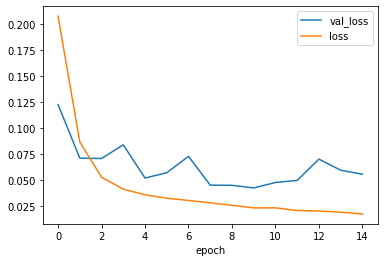

In [3]:

modellog = pd.read_csv(config_vars["csv_log_file"])
#print(modellog.dtypes)

pd.DataFrame.plot(modellog)
ax = plt.gca()
modellog.plot(x = 'epoch', y = 'val_loss', ax = ax)
modellog.plot(x = 'epoch', y = 'loss', ax = ax)

In [4]:
# To evaluate segmentations produced by other segmentation algorithms (e.g. CellProfiler), 
# manually modify the following config var:

#config_vars["labels_out_dir"] = "/data/cellprofiler_segmentations/"
#config_vars["object_dilation"] = 2

# Auxiliary visualization function

In [5]:
# Display prediction along with segmentation to visualize errors

def show(ground_truth, prediction, threshold=0.5, image_name="N"):
    
    # Compute Intersection over Union
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    
    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    C[C>=threshold] = 1
    C[C<threshold] = 0
    missed = np.where(np.sum(C,axis=1) == 0)[0]
    extra = np.where(np.sum(C,axis=0) == 0)[0]

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 4, figsize=(18,6))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects:"+str(len(np.unique(ground_truth))))
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors:"+str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:"+str(len(np.unique(prediction))))
    ax[3].imshow(IOU)
    ax[3].set_title(image_name)

In [6]:
from scipy import ndimage as ndi

# Code inspired by scikit-images source-code for skimage.morphology.remove_small_objects()
def remove_large_objects(image, min_size):
    out = np.copy(image)
    
    if out.dtype == bool:
        selem = ndi.generate_binary_structure(image.ndim,1)
        ccs = np.zeros_like(image, dtype=np.int32)
        ndi.label(image, selem, output=ccs)
    else:
        ccs = out
    component_sizes = np.bincount(ccs.ravel())
    too_large = component_sizes > min_size
    too_large_mask = too_large[ccs]
    out[too_large_mask] = 0
    return out

def pred_to_label(pred, cell_min_size, cell_label=1):
    # Only marks interior of cells (cell_label = 1 is interior, cell_label = 2 is boundary)
    cell_orig = (pred == cell_label)
    
    cell_small = (pred == 1) + (pred == 2)
    cell_small = remove_large_objects(cell_small,100) 
    
    cell_concat = cell_orig + cell_small
    
    cell_orig = skimage.morphology.remove_small_holes(cell_concat, area_threshold=cell_min_size)
    cell_orig = skimage.morphology.remove_small_objects(cell_concat, min_size=cell_min_size)
    # label cells only
    [label, num] = skimage.morphology.label(cell_concat, return_num=True)
    return label

# Run the evaluation
Predictions are stored in Step 03 and loaded here for evaluation

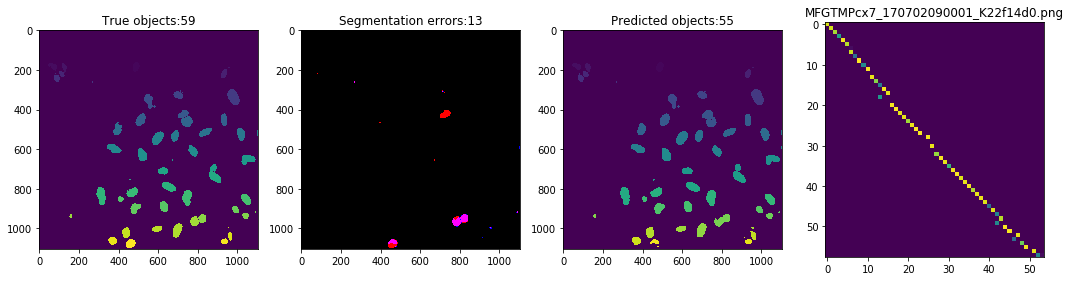

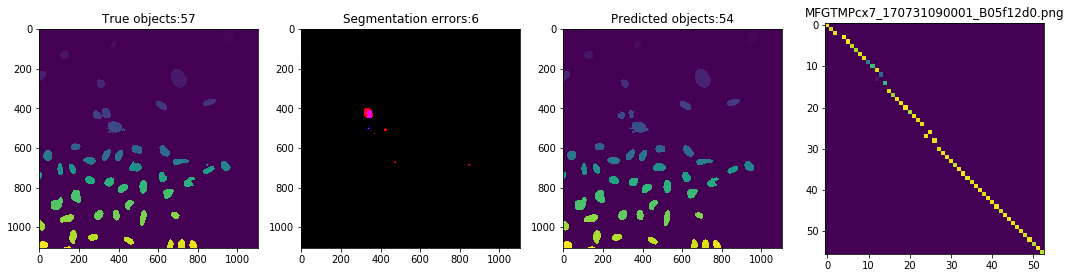

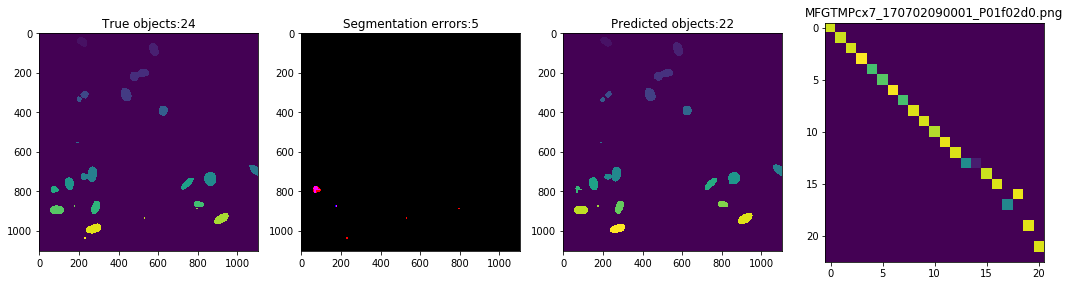

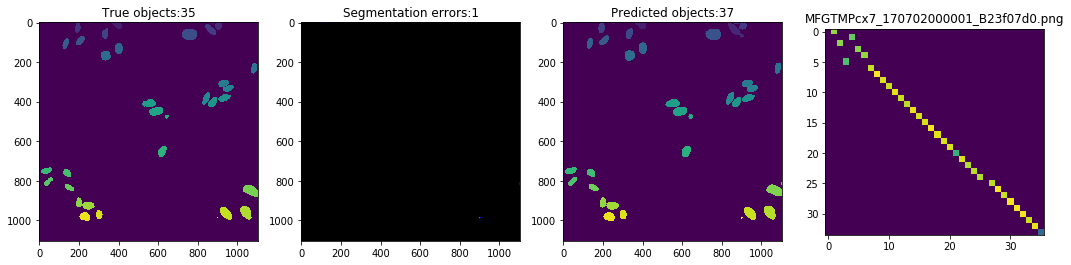

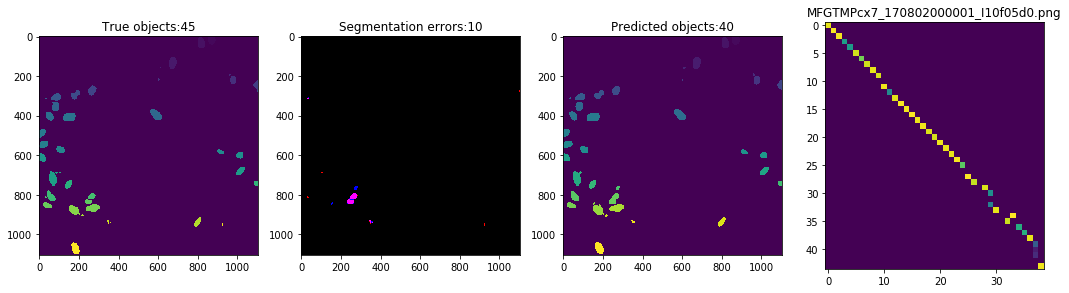

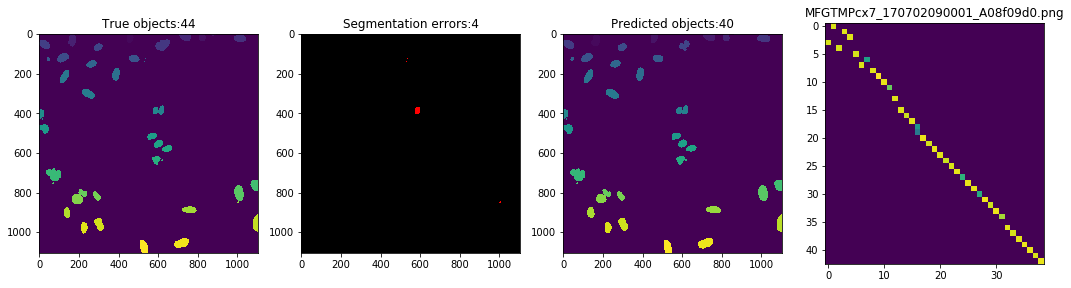

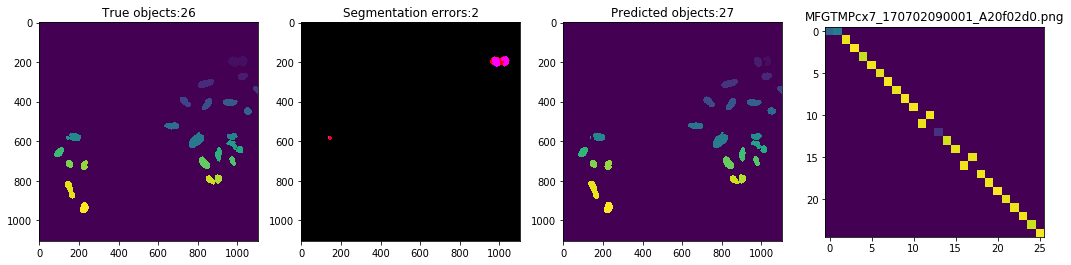

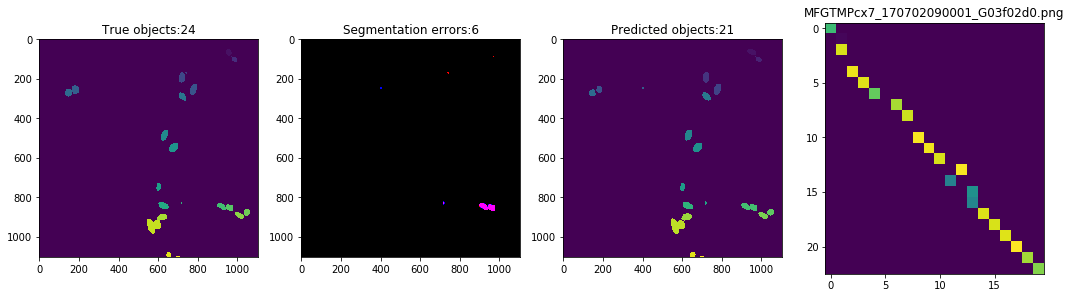

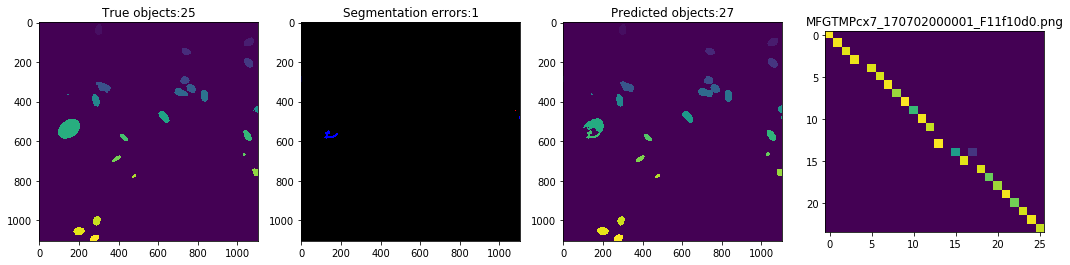

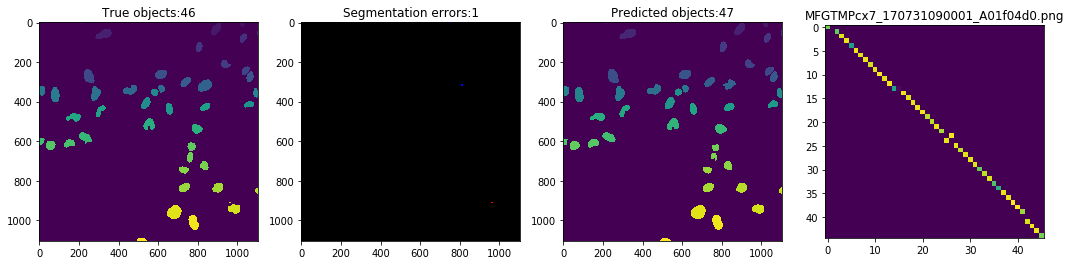

In [7]:
all_images = data_partitions[partition]
from skimage.color import rgb2gray,rgb2lab

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for image_name in all_images:
    # Load ground truth data
    img_filename = os.path.join(config_vars["boundary_labels_dir"], image_name)
    ground_truth = skimage.io.imread(img_filename)
    ground_truth = ground_truth.squeeze()
    #if len(ground_truth.shape) == 3:
    #    ground_truth = rgb2lab(ground_truth)
    #    ground_truth = ground_truth[:,:,0]
    
    ground_truth = np.argmax(ground_truth * [1, 1, 1], -1)
    
    ground_truth = pred_to_label(ground_truth, config_vars["cell_min_size"])
    # Transform to label matrix
    #ground_truth = skimage.morphology.label(ground_truth)
    
    # Load predictions
    pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
    prediction = skimage.io.imread(pred_filename)
    
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)
        
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
    
    # Compute evaluation metrics
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    
    # Display an example image
    #if image_name == all_images[0]:
    show(ground_truth, prediction, image_name=image_name)

# Report of results

,Image,Threshold,F1,Jaccard
3,MFGTMPcx7_170702090001_A20f02d0.png,0.725,0.811765,0.859059
8,MFGTMPcx7_170731090001_B05f12d0.png,0.725,0.796330,0.875065
2,MFGTMPcx7_170702090001_A08f09d0.png,0.725,0.775610,0.887249
7,MFGTMPcx7_170731090001_A01f04d0.png,0.725,0.751648,0.824935
0,MFGTMPcx7_170702000001_B23f07d0.png,0.725,0.737143,0.802390
1,MFGTMPcx7_170702000001_F11f10d0.png,0.725,0.712000,0.770160
5,MFGTMPcx7_170702090001_K22f14d0.png,0.725,0.669643,0.787943
6,MFGTMPcx7_170702090001_P01f02d0.png,0.725,0.668182,0.804628
9,MFGTMPcx7_170802000001_I10f05d0.png,0.725,0.640964,0.788647
4,MFGTMPcx7_170702090001_G03f02d0.png,0.725,0.609302,0.780409


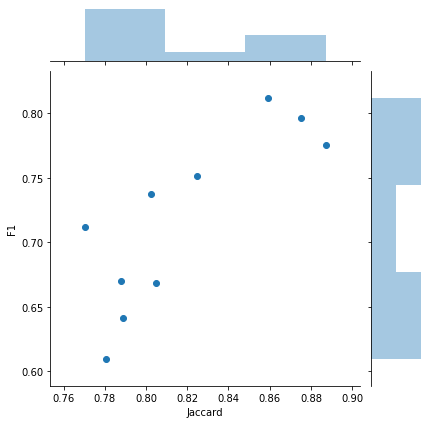

In [8]:
# Display accuracy results

average_performance = results.groupby("Threshold").mean().reset_index()

R = results.groupby("Image").mean().reset_index()
g = sb.jointplot(data=R[R["F1"] > 0.4], x="Jaccard", y="F1")

average_performance
R.sort_values(by="F1",ascending=False)

,Threshold,F1,Jaccard
0,0.50,0.883223,0.818049
1,0.55,0.867981,0.818049
2,0.60,0.854542,0.818049
3,0.65,0.836369,0.818049
4,0.70,0.818554,0.818049
5,0.75,0.787470,0.818049
6,0.80,0.768514,0.818049
7,0.85,0.715905,0.818049
8,0.90,0.566898,0.818049
9,0.95,0.073131,0.818049


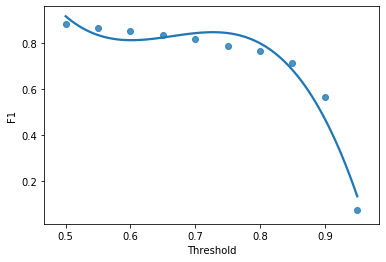

In [9]:
# Plot accuracy results

sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)
average_performance

In [10]:
# Compute and print Average F1

average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

Average F1 score: 0.7172586802219468
Jaccard index: 0.8180485154535735


In [11]:
# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,250,625,900,10000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

Area
Tiny nuclei      48
Small nuclei      2
Normal nuclei     3
Large nuclei     20
Name: False_Negative, dtype: int64

In [12]:
# Summarize splits and merges

print("Splits:",np.sum(splits_merges["Splits"]))
print("Merges:",np.sum(splits_merges["Merges"]))

Splits: 2
Merges: 6


In [13]:
# Report false positives

print("Extra objects (false postives):",results[results["Threshold"].round(3) == 0.7].sum()["FP"])

Extra objects (false postives): 58
